In [1]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from typing import List, Dict
from collections import deque, namedtuple

import random
import math

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Solving the Lunar Lander Environment with Deep Q-Learning

This notebook aims to demonstrate that two completely different problems can be solved using the same reinforcement learning technique in an analogous manner. It only requires modeling the problem as a Markov Decision Process (MDP) and applying the algorithm.

The [Lunar Lander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) has a continuous state space, making it much more challenging to solve using tabular methods. Therefore, this environment is ideal for applying Deep Q-Learning and its variations. The main goal of Lunar Lander is to use three spacecraft thrusters to land as close as possible to a landing platform. An episode is defined as a win/loss based on the final score obtained.

<img src="media/lunar_lander.gif" width="200">

Below are some important details for modeling the environment as a Markov Decision Process (MDP):

## Action Space

The action space is discrete and contains integers in the range {0, 3}. An action specifies the direction of a movement:

* 0: Do nothing
* 1: Activate the left thruster
* 2: Activate the main thruster
* 3: Activate the right thruster

## State Space

The state vector has eight elements: x & y coordinates, x & y velocities, angle, rotational velocity, and two boolean variables indicating whether the spacecraft's legs are touching the ground.

## Rewards

At each time step, the reward:

* increases/decreases if the spacecraft approaches/distances from the landing platform.
* increases/decreases if the spacecraft moves slower/faster.
* decreases the more tilted the spacecraft is.
* increases by 10 points for each leg of the spacecraft touching the ground.
* decreases by 0.03 points for each frame in which a side thruster is active.
* decreases by 0.3 points for each frame in which the main thruster is active.
At the end of the episode, an additional reward of -100 or +100 is assigned if the spacecraft crashes or lands safely.

If the final score is greater than 200, the episode is considered solved.

## Creating the Model

In Deep Q-Learning, the Q-values of each action associated with a state are calculated using a neural network. In other words, the neural network receives a state vector as input and returns a Q-value vector, where each element represents the Q-value of an action. A Q-value can be interpreted as "the expected total accumulated reward for taking action A in state S and then following the same policy until the end of the episode."

The Lunar Lander's state vector is already in a format suitable for input into a neural network, so no formatting is necessary—just transform it into a PyTorch tensor.

In [2]:
class Qnet(nn.Module):
    def __init__(self, layer_sizes: List[int] = [64, 64], n_actions=4):
        super().__init__()

        # construindo a rede neural
        layers = []
        input_size = 8
        for n_neurons in layer_sizes:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            input_size = n_neurons
        layers.append(nn.Linear(input_size, n_actions))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        x = self.nn(x)
        return x

## Replay Buffer

Replay buffers are used to store state transitions observed during the training process. The neural network uses batches of transitions (not necessarily sequential!) to calculate the loss and update its weights. The use of replay buffers makes the learning process more efficient because it allows the network to learn from a transition multiple times, as well as helps increase the stability of the neural network training.

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'terminated'))

class ReplayBuffer:
    def __init__(self, capacity=1024):
        self.buffer = deque([], maxlen=capacity)
    
    def push(self, *args):
        """ Save a transition into the buffer."""
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


## Sampling Actions with the $\epsilon$-Greedy Policy

At the end of training, the best action for each state is expected to be the one with the highest Q-value. However, for Q-Learning to converge properly, the agent needs to "explore" the environment well at the beginning of training. That is, the agent should visit a wide range of states, even if they are not necessarily optimal. A widely used technique for this purpose is the $\epsilon$-greedy policy. It forces the agent to choose actions randomly with a frequency that decreases as training progresses.

In [4]:
@torch.no_grad()
def get_action(model, state, epsilon, n_actions=4):
    if torch.rand(1) < epsilon:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(torch.tensor(state, dtype=torch.float32).float().to(DEVICE))
    return torch.argmax(qvals).item()

## Neural Network Training
At each training step, the agent will execute an action and use the information returned by the environment to calculate a loss and update its weights to minimize it. The loss used will be the mean squared error between the selected Q-value and the highest Q-value of the next state, calculated using the network with weights from the previous update:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note that, therefore, two neural networks with the same architecture will be needed, but one will have weights delayed by one iteration compared to the other.

In [5]:
def update_q_net(model: Qnet, 
                 model_target: Qnet,
                 optimizer: torch.optim.Optimizer, 
                 batch_of_transitions: List[Transition],
                 gamma):
    
    # Convert a list of Transitions into a Transition of lists
    # Check: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Transition(*zip(*batch_of_transitions))
    
    # transformando o batch de estados em um tensor
    states = torch.cat(batch.state)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    next_states = torch.cat(batch.next_state)
    terminated = torch.cat(batch.terminated)
    
    predictions = model(states).gather(1, actions.unsqueeze(1)).squeeze() # select the q-value of the action taken

    # if state is terminal, the value is the reward itself
    with torch.no_grad():
        targets = rewards + gamma * model_target(next_states).max(-1).values * (1 - terminated.int()) # else rewards + gamma * max_a Q(s', a)
    
    loss = F.mse_loss(predictions, targets)

    # update the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return model

## Training Loop

In the training loop, we will combine all the functions developed so far. The main idea is to define a maximum number of episodes (from the initial stage to the final stage) so that the agent collects experiences from the environment and optimizes its Q-value table.

In [6]:
def evaluate(metrics: Dict, show_result=False):
    rewards = torch.tensor(metrics['episode_rewards'])
    plt.figure(1)
    plt.clf
    plt.title('Total reward of each episode')
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.grid()
    plt.plot(rewards)

    # Take 100 episode averages and plot them too
    if metrics['avg_reward'] is not None: 
        x = range(49, 49 + len(metrics['avg_reward']))
        plt.plot(x, metrics['avg_reward'].numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated

    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())


In [7]:
def train(
        env: gym.Env, 
        model: Qnet,
        total_steps=450_000,
        replay_buffer_size=2 ** 20, # replay buffer size
        batch_size=128, # batch size
        gamma=0.99,
        learning_rate=5e-4,
        learning_freq=1,
        target_update_freq=100,
        tau=1.0,
        epsilon_0 = 1, # initial probability of taking a random action
        epsilon_f=0.05, # final probability of taking a random action (after decay)
        epsilon_decay = 100_000 # step in which epsilon will be approximately epsilon_f + 0.36 * (epsilon_0 - epsilon_f)
        ):
    
    model_target = deepcopy(model)

    def eps_scheduler(step):
        return epsilon_f + (epsilon_0 - epsilon_f) * math.exp(-1. * step / epsilon_decay)

    replay_buffer = ReplayBuffer(replay_buffer_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    state, _ = env.reset()
    total_reward = 0
    metrics = {
        'episode_rewards': [],
        'avg_reward': None,
    }
    episode_step = 0
    truncated = False

    for global_step in range(total_steps):
        epsilon = eps_scheduler(global_step)

        # observe
        action = get_action(model, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        replay_buffer.push(
            torch.tensor([state], dtype=torch.float32).to(DEVICE), 
            torch.tensor([action], dtype=torch.int64).to(DEVICE), 
            torch.tensor([reward], dtype=torch.float32).to(DEVICE), 
            torch.tensor([next_state], dtype=torch.float32).to(DEVICE), 
            torch.tensor([terminated], dtype=torch.float32).to(DEVICE) 
            )
        state = next_state
        total_reward += reward
        episode_step += 1
        done = terminated or truncated

        # update
        if global_step > batch_size and global_step % learning_freq == 0:
            batch = replay_buffer.sample(batch_size)
            model = update_q_net(model, model_target, optimizer, batch, gamma)

        # update target network
        if global_step % target_update_freq == 0:
            model_target.load_state_dict(model.state_dict())

            for target_net_param, q_net_param in zip(model_target.parameters(), model.parameters()):
                    target_net_param.data.copy_(
                        tau * q_net_param.data + (1.0 - tau) * target_net_param.data
                    )

        # evaluating
        if done:
            metrics['episode_rewards'].append(total_reward)
            if len(metrics['episode_rewards']) > 50:
                metrics['avg_reward'] = torch.tensor(metrics['episode_rewards']).float().unfold(0, 50, 1).mean(1)
                print(f'avg reward: {metrics["avg_reward"][-1]}')
            print(f'current step: {global_step}, epsilon: {epsilon:.2f}')
            # if global_step % 10_000 == 0:
            #     evaluate(metrics)
            evaluate(metrics)
            total_reward = 0
            state, _ = env.reset()
            episode_step = 0
            truncated = False

    evaluate(metrics, show_result=True)
    return model

## Training

Everything is set up, so now we can run the algorithm!

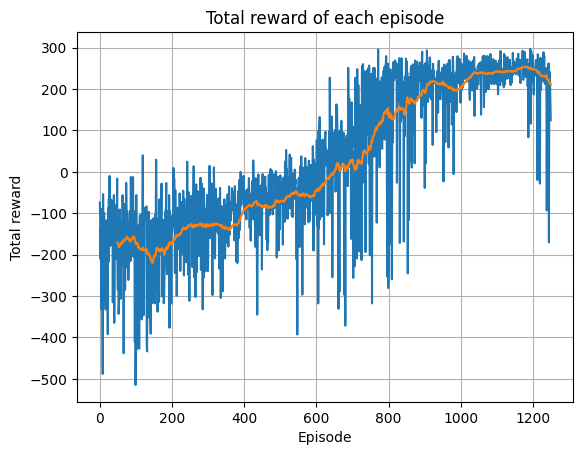

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
lunar_lander = gym.make('LunarLander-v2')
q_net = Qnet().to(DEVICE)
trained_q_net = train(lunar_lander, q_net, verbose=True)

## Testing the agent

The function below will run an episode with the trained agent.

In [18]:
def test(env: gym.Env, 
          q_net,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_net, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    total_reward = torch.tensor(total_rewards, dtype=torch.float32)
    return torch.mean(total_reward)

test(gym.make('LunarLander-v2', render_mode="human"), trained_q_net)

tensor(258.7786)

### Exercise - Non-Deterministic Environments

The Lunar Lander, like Cliff Walking, also has a version with random wind that makes the environment non-deterministic. Try to find a learning rate that allows solving this version of the environment! Is it higher or lower than the rate used previously? Is the effect of a non-deterministic environment on the learning rate analogous to what was observed in the tabular algorithm?

avg reward: -259.6629943847656
current step: 7496, epsilon: 0.93


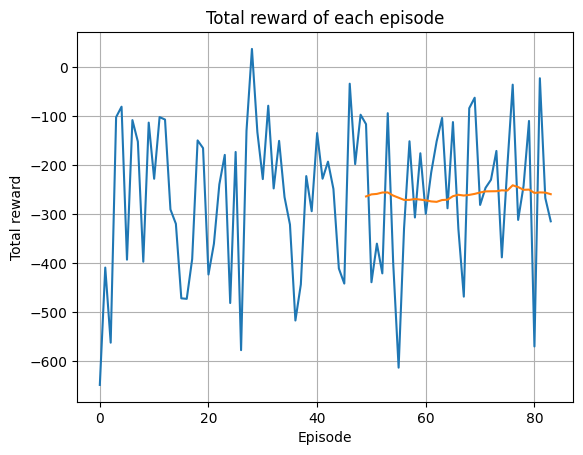

<Figure size 640x480 with 0 Axes>

In [19]:
nd_lunar_lander = gym.make('LunarLander-v2', enable_wind=True, render_mode="human")
nd_q_net = Qnet()
# trained_nd_q_net = train(nd_lunar_lander, nd_q_net, total_steps=450_000, epsilon_decay=100_000, learning_rate=5e-4, replay_buffer_size=2 ** 20, batch_size=128, verbose=True)